In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# import hyperas
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.data import Dataset

import tensorflow as tf

import statsmodels.api as sm

from hyperas import optim
from hyperopt import Trials, tpe


from hyperas import optim
from hyperas.distributions import choice, uniform
from hyperopt import STATUS_OK

In [5]:
df = pd.read_csv("differenced_data.csv")
df.drop(["Date"], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27139 entries, 0 to 27138
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temp              27139 non-null  float64
 1   dewp              27139 non-null  float64
 2   slp               27139 non-null  float64
 3   visib             27139 non-null  float64
 4   wdsp              27139 non-null  float64
 5   max               27139 non-null  float64
 6   min               27139 non-null  float64
 7   fog               27139 non-null  float64
 8   rain_drizzle      27139 non-null  float64
 9   snow_ice_pellets  27139 non-null  float64
 10  hail              27139 non-null  float64
 11  thunder           27139 non-null  float64
dtypes: float64(12)
memory usage: 2.5 MB


In [6]:
# df = df.diff(periods=180).dropna().reset_index().drop("index", axis=1)
# df

In [7]:
# Train, Validation, Test Split
train_df = df[0:int(len(df)*.7)]
val_df = df[int(len(df)*.7):int(len(df)*.9)]
test_df = df[int(len(df)*.9):]


In [8]:
scaler = StandardScaler()
scaler.fit(train_df)


StandardScaler()

In [9]:
train_scaled = scaler.transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

In [10]:
# Various window parameters
input_width = 6
label_width = 6
shift = 1
label_columns = None

In [11]:
column_indeces = {name: i for i, name in enumerate(train_df.columns)}
if label_columns is not None:
    label_column_indeces = {name: i for i, name in enumerate(label_columns)}

window_size = input_width + shift

input_slice = slice(0, input_width)
input_indeces = np.arange(window_size)[input_slice]

label_start = window_size - label_width
label_slice = slice(label_start, None)
label_indeces =  np.arange(window_size)[label_slice]

In [12]:
def split_window(features):
    inputs = features[:, input_slice, :]
    labels = features[:, label_slice, :]
    if label_columns is not None:
        labels = tf.stack(
            [labels[:, :, column_indeces[name]] for name in label_columns], axis=1)

    inputs.set_shape([None, input_width, None])
    labels.set_shape([None, label_width, None])

    return inputs, labels

In [13]:
# Examples for testing
example_window = tf.stack([np.array(train_scaled[:window_size]),
                        np.array(train_scaled[100:100+window_size]),
                        np.array(train_scaled[200:200+window_size])])
example_inputs, example_labels = split_window(example_window)



In [14]:
example_labels.shape

TensorShape([3, 6, 12])

In [15]:
def make_dataset(data):
    data = np.array(data, dtype=np.float32)
    dset = timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32
    )

    dset = dset.map(split_window)
    return dset

In [16]:
def compile_fit(model, train, val, patience=2, max_epochs=10, optimizer="adam"):
    e_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience, mode="min")

    model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=optimizer,
                    metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(train, epochs=max_epochs, validation_data = val, callbacks=[e_stop])
    return history

In [17]:
model_train = make_dataset(train_scaled)
model_val = make_dataset(val_scaled)
model_test = make_dataset(test_scaled)


In [18]:
def data():
    return model_train, model_val

In [19]:
def make_models(lstm_size, dense_size, dense_layer_num, activation, optimizer):

    model = Sequential()
    model.add(LSTM(lstm_size, return_sequences=True))
    for i in range(dense_layer_num):
        model.add(Dense(units=dense_size, activation=activation))
    model.add(Dense(12))

    e_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode="min")
    model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=optimizer,
                    metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(model_train, epochs=15, validation_data=model_val, callbacks=[e_stop])

    return {"loss": np.amin(history.history["val_loss"]), "status": STATUS_OK, "model":model}

In [20]:
histories = []
lstm_sizes = [16, 64]
dense_sizes = [50, 200]
dense_layers = [0, 1, 2]
activations = ["relu"]
optimizers = ["adam"]
for lstm_size in lstm_sizes:
    for dense_size in dense_sizes:
        for dense_layer_num in dense_layers:
            for activation in activations:
                for optimizer in optimizers:
                    histories.append(make_models(lstm_size=lstm_size,
                                            dense_size=dense_size,
                                            dense_layer_num=dense_layer_num,
                                            activation=activation,
                                            optimizer=optimizer))
        

Epoch 1/15
594/594 [==============================] - 4s 7ms/step - loss: 0.8627 - mean_absolute_error: 0.5576 - val_loss: 0.5621 - val_mean_absolute_error: 0.4737
Epoch 2/15
594/594 [==============================] - 3s 5ms/step - loss: 0.7642 - mean_absolute_error: 0.5432 - val_loss: 0.5327 - val_mean_absolute_error: 0.4693
Epoch 3/15
594/594 [==============================] - 3s 5ms/step - loss: 0.7355 - mean_absolute_error: 0.5398 - val_loss: 0.5203 - val_mean_absolute_error: 0.4676
Epoch 4/15
594/594 [==============================] - 3s 5ms/step - loss: 0.7194 - mean_absolute_error: 0.5376 - val_loss: 0.5141 - val_mean_absolute_error: 0.4668
Epoch 5/15
594/594 [==============================] - 3s 5ms/step - loss: 0.7085 - mean_absolute_error: 0.5354 - val_loss: 0.5105 - val_mean_absolute_error: 0.4658
Epoch 6/15
594/594 [==============================] - 3s 6ms/step - loss: 0.7008 - mean_absolute_error: 0.5337 - val_loss: 0.5080 - val_mean_absolute_error: 0.4632
Epoch 7/15
594/5

KeyboardInterrupt: 

In [21]:
losses = []
for hist in histories:
    losses.append(hist["loss"])
losses

[0.4965348541736603]

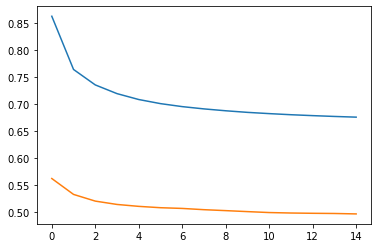

In [22]:
test_model = histories[0]["model"]
plt.plot(test_model.history.history["loss"], label="train")
plt.plot(test_model.history.history["val_loss"], label="test")
plt.show()

In [23]:
predictions = histories[0]["model"].predict(model_test)
predictions = scaler.inverse_transform(predictions)

In [25]:
pred_reshape = predictions.reshape((-1,12))

In [26]:
output_df = pd.DataFrame(predictions[:,5,:], columns=df.columns)
output_df

,temp,dewp,slp,visib,wdsp,max,min,fog,rain_drizzle,snow_ice_pellets,hail,thunder
0,4.003433,6.319040,-2.019623,-1.098343,1.061848,2.643108,4.003083,0.257178,0.219726,-0.011042,0.000419,0.119063
1,-4.007645,-5.468711,3.035544,-1.159051,-1.729119,-2.342621,-5.124039,0.159219,0.171873,-0.009267,0.005889,0.215906
2,-9.955940,-12.749149,2.685545,1.376317,-1.813230,-3.736769,-13.744667,-0.290666,-0.123300,-0.001612,-0.005567,0.033545
3,-0.850729,0.559858,2.612153,-0.923387,-0.834746,0.138183,-1.028992,0.119979,0.032075,0.024026,0.005175,-0.022943
4,-0.984480,-1.208254,0.995953,0.104126,-0.404890,-0.403781,-1.437900,0.032162,0.186759,0.004348,0.002292,0.100652
...,...,...,...,...,...,...,...,...,...,...,...,...
2703,0.349148,-0.187439,0.398438,0.408169,-0.413517,1.280450,-0.303417,-0.039502,-0.078916,-0.014161,-0.006498,-0.042234
2704,1.841341,4.403157,-3.094026,-1.322567,-0.679040,6.211963,-0.780335,0.137565,0.390358,-0.006163,-0.005348,0.062478
2705,6.653335,8.848889,-5.008136,-1.598076,1.872999,1.541250,10.674270,-0.003267,0.470762,-0.000644,-0.001585,0.158009
2706,0.940116,2.868357,-0.652596,-1.647608,1.073715,2.357478,0.425217,0.164415,-0.087147,0.057239,-0.001680,-0.006414


In [27]:
resid = output_df["temp"] - test_df[6:].reset_index(drop=True)["temp"]
resid

0       2.943433
1      -3.947645
2      -6.535940
3      -1.110729
4      -2.924480
          ...   
2703   -2.790852
2704    0.321341
2705    7.233335
2706    0.920116
2707   -4.494039
Name: temp, Length: 2708, dtype: float64

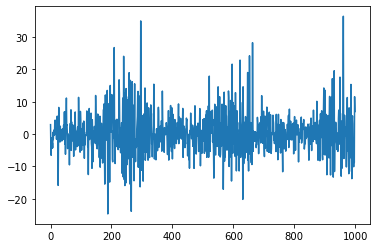

In [28]:
plt.plot(resid[:1000])

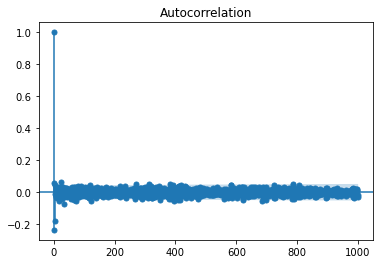

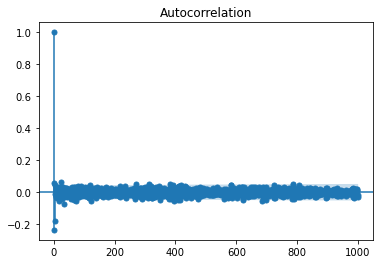

In [30]:
sm.graphics.tsa.plot_acf(resid, lags=1000)

In [42]:
inv_one = []
for i in range(1, len(output_df)):
    values = output_df.iloc[i] + output_df.iloc[i-1]
    inv_one.append(values)

inv_df = pd.DataFrame(inv_one)

In [43]:
inv_df

,temp,dewp,slp,visib,wdsp,max,min,fog,rain_drizzle,snow_ice_pellets,hail,thunder
0,-0.004212,0.850329,1.015922,-2.257394,-0.667270,0.300487,-1.120956,0.416397,0.391599,-0.020309,0.006308,0.334969
1,-13.963585,-18.217861,5.721089,0.217266,-3.542349,-6.079390,-18.868706,-0.131447,0.048573,-0.010879,0.000322,0.249451
2,-10.806669,-12.189291,5.297698,0.452930,-2.647977,-3.598586,-14.773660,-0.170687,-0.091225,0.022415,-0.000392,0.010601
3,-1.835209,-0.648396,3.608106,-0.819260,-1.239636,-0.265598,-2.466892,0.152141,0.218834,0.028375,0.007467,0.077709
4,-1.994451,-2.384038,1.545007,0.105465,-0.401871,-2.005098,-2.680995,0.128510,-0.227426,0.002175,-0.001254,-0.352424
...,...,...,...,...,...,...,...,...,...,...,...,...
2702,0.084768,-1.179880,3.374220,0.643064,0.691587,0.100604,-0.370113,-0.009707,0.238533,-0.014144,-0.009280,0.159136
2703,2.190489,4.215718,-2.695589,-0.914397,-1.092557,7.492414,-1.083752,0.098063,0.311442,-0.020325,-0.011846,0.020243
2704,8.494676,13.252047,-8.102162,-2.920643,1.193959,7.753214,9.893935,0.134298,0.861121,-0.006807,-0.006933,0.220487
2705,7.593451,11.717246,-5.660732,-3.245684,2.946714,3.898728,11.099487,0.161148,0.383616,0.056595,-0.003265,0.151595
